<a href="https://colab.research.google.com/github/ChintPatel/CMPE258-HW6/blob/main/Part2_Advanced_Keras_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, constraints, initializers
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

In [2]:
# ✅ Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, y_train = x_train[:5000] / 255.0, y_train[:5000]
x_test, y_test = x_test[:1000] / 255.0, y_test[:1000]
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

EPOCHS = 5
BATCH_SIZE = 256

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/5
Step 0, Loss: 2.4498, Accuracy: 0.1562
Step 100, Loss: 0.7440, Accuracy: 0.6609
Training acc over epoch: 0.7012
Epoch 2/5
Step 0, Loss: 0.8388, Accuracy: 0.7188
Step 100, Loss: 0.8484, Accuracy: 0.8131
Training acc over epoch: 0.8210
Epoch 3/5
Step 0, Loss: 0.2715, Accuracy: 0.9062
Step 100, Loss: 0.3148, Accuracy: 0.8233
Training acc over epoch: 0.8316
Epoch 4/5
Step 0, Loss: 0.4333, Accuracy: 0.8125
Step 100, Loss: 0.4924, Accuracy: 0.8441
Training acc over epoch: 0.8498
Epoch 5/5
Step 0, Loss: 0.3811, Accuracy: 0.8125
Step 100, Loss: 0.4213, Accuracy: 0.8639
Training acc over epoch: 0.8696


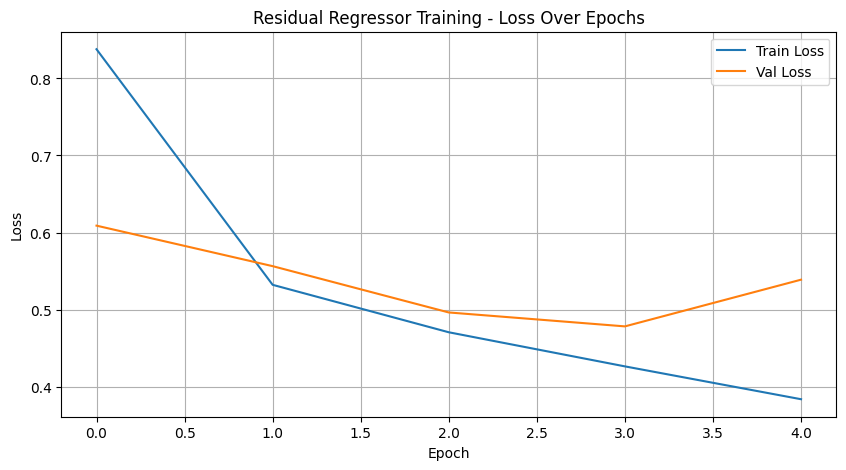

In [6]:
# ✅ Plotting Function

def plot_custom_loop(train_losses, val_losses, title="Custom Training Loop"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{title} - Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

# ✅ i) Custom Learning Rate Scheduler: One Cycle LR
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, max_lr, steps):
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []

    def on_train_batch_begin(self, batch, logs=None):
        step = self.model.optimizer.iterations.numpy()
        lr = self.max_lr * (1 - step / self.steps)
        self.model.optimizer.lr.assign(lr)
        self.lrs.append(lr)

# ✅ ii) Custom Dropout: MC Alpha Dropout
class MCAlphaDropout(layers.AlphaDropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# ✅ iii) Custom Normalization Layer: MaxNormDense
class MaxNormDense(layers.Layer):
    def __init__(self, units, max_value=1.0):
        super().__init__()
        self.units = units
        self.max_value = max_value

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="he_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        clipped_w = tf.clip_by_norm(self.w, clip_norm=self.max_value, axes=0)
        return tf.matmul(inputs, clipped_w) + self.b

# ✅ iv) TensorBoard
log_dir = os.path.join("logs", "custom_keras", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir)

# ✅ v) Custom Loss: Huber Loss
class HuberLoss(keras.losses.Loss):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        is_small_error = error <= self.delta
        small_error_loss = 0.5 * tf.square(error)
        big_error_loss = self.delta * (error - 0.5 * self.delta)
        return tf.where(is_small_error, small_error_loss, big_error_loss)

# ✅ vi) Custom Activation, Initializer, Regularizer, Constraint
leaky_relu = tf.nn.leaky_relu

def my_glorot_initializer(shape, dtype=None):
    fan_in, fan_out = shape[0], shape[1]
    limit = tf.sqrt(6. / (fan_in + fan_out))
    return tf.random.uniform(shape, -limit, limit, dtype=dtype)

class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, l1=0.01):
        self.l1 = l1
    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x))

class MyPositiveWeights(constraints.Constraint):
    def __call__(self, w):
        return tf.nn.relu(w)

# ✅ vii) Custom Metric: Huber Metric
class HuberMetric(keras.metrics.Metric):
    def __init__(self, delta=1.0, name='huber_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.huber = HuberLoss(delta)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        loss = self.huber(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(tf.cast(tf.size(loss), tf.float32))

    def result(self):
        return self.total / self.count

# ✅ viii) Custom Layers: AddGaussianNoise, MyDense
class AddGaussianNoise(layers.Layer):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev
    def call(self, inputs, training=False):
        return inputs + tf.random.normal(tf.shape(inputs), stddev=self.stddev) if training else inputs

class MyDense(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,), initializer='zeros')
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

# ✅ ix) Custom Model: ResidualBlock + ResidualRegressor
class ResidualBlock(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense1 = layers.Dense(units, activation='relu')
        self.dense2 = layers.Dense(units)
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return layers.add([x, inputs])

class ResidualRegressor(keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(64, activation='relu')
        self.res_block = ResidualBlock(64)
        self.out = layers.Dense(output_dim, activation='softmax')
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense(x)
        x = self.res_block(x)
        return self.out(x)

# ✅ x) Custom Optimizer: MyMomentumOptimizer (wrapper around SGD)
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, name="MyMomentum", **kwargs):
        super().__init__(name, **kwargs)
        self._learning_rate = learning_rate
        self._momentum = momentum

    def get_config(self):
        return {"learning_rate": self._learning_rate, "momentum": self._momentum}

    @tf.function
    def _resource_apply_dense(self, grad, var, apply_state):
        if var.ref() not in self._slots:
            self.add_slot(var, "momentum")
        momentum_var = self.get_slot(var, "momentum")
        momentum = momentum_var * self._momentum - grad * self._learning_rate
        momentum_var.assign(momentum)
        var.assign_add(momentum)

# ✅ xi) Custom Training Loop with Plot
model = ResidualRegressor(10)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    epoch_loss = 0
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            loss = loss_fn(y_batch, logits)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss.numpy()
        train_acc_metric.update_state(y_batch, logits)

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {train_acc_metric.result().numpy():.4f}")

    train_acc = train_acc_metric.result()
    avg_loss = epoch_loss / (step + 1)
    train_losses.append(avg_loss)
    print(f"Training acc over epoch: {train_acc:.4f}")
    train_acc_metric.reset_state()

    # Validation Loss
    val_loss_epoch = 0
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        val_loss = loss_fn(y_batch_val, val_logits)
        val_loss_epoch += val_loss.numpy()
    val_losses.append(val_loss_epoch / len(val_dataset))

plot_custom_loop(train_losses, val_losses, title="Residual Regressor Training")
